In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:
df = pd.read_csv('data/gd.csv', delimiter=';')

In [3]:
#df.insert(0, 'ones', 1.)

In [4]:
np.ones(df.shape[1])

array([1., 1., 1.])

In [5]:
df.y = df.y * np.random.rand(df.shape[0])
df

,x,y,iter
0,5.000000,1.625079e-01,0
1,4.000000,2.708935e+00,1
2,3.375300,3.145457e+00,2
3,2.908990,1.480497e+00,3
4,2.536090,2.082132e+00,4
...,...,...,...
87,0.000235,2.114849e-04,87
88,0.000210,1.846161e-04,88
89,0.000188,3.554679e-05,89
90,0.000169,9.120874e-07,90


In [6]:
df = df.drop(columns = 'iter')

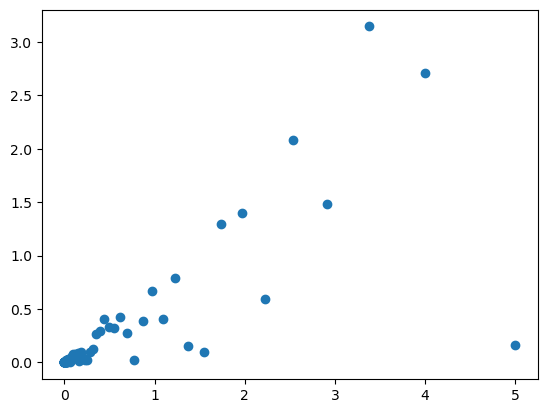

In [7]:
plt.scatter(df.x, df.y)

In [8]:
x = df.drop(columns = 'y')
y = df.y
weights = np.ones(x.shape[1])
weights

array([1.])

In [9]:

2/x.shape[0] * np.dot((np.dot(x, weights)-y), x)


array([1.05391288])

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns



In [11]:
df = pd.read_csv('data/Raisin_Dataset.csv')
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [12]:
df.Class.value_counts()

Class
Kecimen    450
Besni      450
Name: count, dtype: int64

In [13]:
df.Class = df.Class.map({'Kecimen':0, 'Besni': 1})

<Axes: >

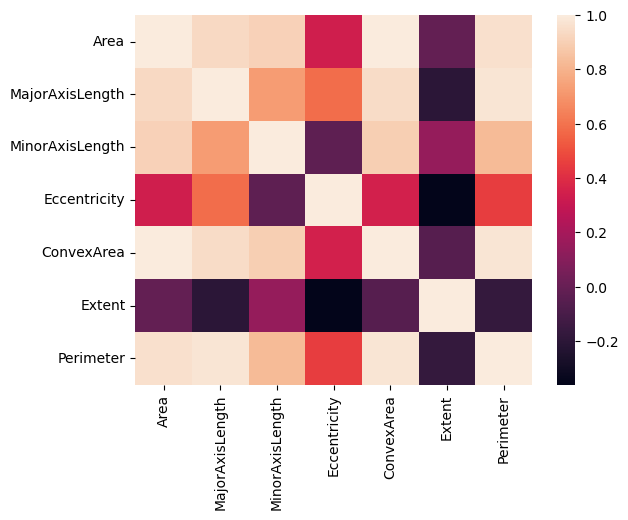

In [14]:
sns.heatmap(df.drop(columns = 'Class').corr())

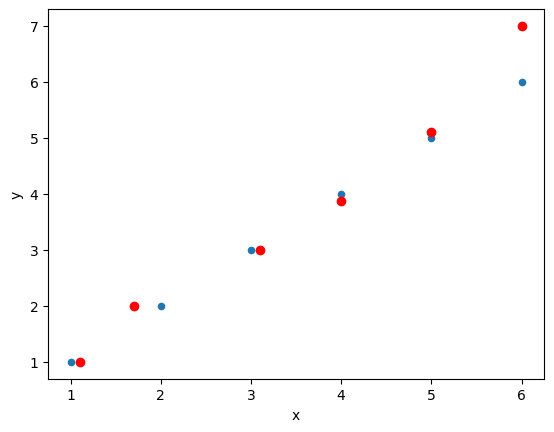

In [15]:
x_train = pd.DataFrame({'x':[1,2,3,4,5, 6], 'y':[1,2,3,4,5, 6]})
target = pd.Series([1,1,1,0,0,0])
x_train.assign(t = target.values)

x_test = pd.DataFrame({'x':[1.1, 1.7, 3.1, 4,5,6], "y" : [1,2,3, 3.88, 5.1, 7]})
x_train.plot(kind = 'scatter', x = 'x', y = 'y')
plt.scatter(x_test.x, x_test.y, c = 'red')

In [78]:
class TwoPointers():
    def __init__(self, col, sep):
        self.col = col
        self.sep = sep
        self.right = None
        self.left = None
        self.left_prob = None
        self.right_prob = None
        self.is_right = None # 1 или 0


def entropy_shennon(y: np.array):
    ans = 0
    for i in np.unique(y):
        si = (y == i).sum() / y.shape[0]
        ans -= si * np.log2(si)
    return ans

def  IG (*y_arr):
    ans = entropy_shennon(y_arr[0])
    N = y_arr[0].shape[0]
    for yi in y_arr[1:]:
        Ni = yi.shape[0]
        ans -= Ni/N * entropy_shennon(yi) 
    return ans

def get_best_split(X:np.array, y:np.array):
    ig = 0
    split_value = 0
    col_name = ''
    for col in range(X.shape[1]):
        unique_sorted = np.sort(np.unique(X[:, col]))
        separators = np.zeros(unique_sorted.shape[0] - 1)
        for i in range(unique_sorted.shape[0] - 1):
            separators[i] = (unique_sorted[i] + unique_sorted[i+1]) / 2
        
        for sep in separators:
            right = y[X[:, col] > sep]
            left = y[X[:, col] <= sep]
            ig_local = IG(y, right, left)
            
            if ig_local > ig:
                ig = ig_local
                col_name = col
                split_value = sep 
    return (col_name, split_value, ig)

def tree_builder(x, y, curr_depth, Node, min_samples_split, is_right):
        if (x.shape[0] < min_samples_split) or (np.unique(y).shape[0] <=1):
            if is_right == 1:
                Node.right_prob = (y == 1).sum() / y.shape[0]
                Node.left_prob = 0.0
            else:
                Node.left_prob = (y == 1).sum() / y.shape[0]
                Node.right_prob = 0.0
            return Node

        else:
            best_split = get_best_split(x, y)
            
            right_x = x[x[:, best_split[0]] > best_split[1]]
            left_x  = x[x[:,  best_split[0]] <= best_split[1]]
            
            right_y = y[x[:, best_split[0]] > best_split[1]]
            left_y = y[x[:,  best_split[0]] <= best_split[1]]
            
            Node.col = best_split[0]
            Node.sep = best_split[1]
            Node.left = tree_builder(left_x, left_y, curr_depth + 1, TwoPointers(None, None), min_samples_split, 0)
            Node.right = tree_builder(right_x, right_y, curr_depth + 1, TwoPointers(None, None), min_samples_split, 1)
        
        return Node
            

def tree_reader(node, indent = ''):
    if (node.left == None) and (node.right == None):
        if node.is_right == 1:
            print(indent, 'right_prob =', node.right_prob)
        else:print(indent, 'right_prob =', node.right_prob)

    else:
        print(indent, 'col:', node.col, 'sep:', node.sep)
        tree_reader(node.right, indent + '  ')
        tree_reader(node.left, indent + '  ')
        
class MyTreeClf():

    def __init__(self, max_depth, min_samples_split, max_leafs):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leafs = max_leafs
        self.leafs_cnt = 0
        self.tree = None
    
    def fit (self, X, y):
        self.tree = TwoPointers(None, None)
        X = X.values
        y = y.values
        tree_builder(X, y, 0, self.tree, self.min_samples_split, 0)
    
    def display_tree(self):
        tree_reader(self.tree)
    
            

In [79]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

In [80]:
df = pd.DataFrame(data.data)
y = pd.Series(data.target)

In [81]:
tree_classifier = MyTreeClf(5, 10, 20)

In [82]:
tree_classifier.fit(df, y)

In [83]:
tree_classifier.display_tree()

 col: 22 sep: 105.95
   col: 22 sep: 117.45
     col: 19 sep: 0.001547
       right_prob = 0.0
       right_prob = 0.0
     col: 24 sep: 0.1361
       col: 1 sep: 13.42
         right_prob = 0.0
         right_prob = 0.0
       col: 21 sep: 25.67
         col: 0 sep: 15.02
           right_prob = 0.0
           right_prob = 0.0
         right_prob = 0.0
   col: 27 sep: 0.13505
     col: 21 sep: 27.575
       right_prob = 0.0
       col: 28 sep: 0.35785
         right_prob = 0.2
         right_prob = 0.0
     col: 13 sep: 48.975
       right_prob = 0.5
       col: 21 sep: 30.145
         col: 11 sep: 0.8596
           col: 20 sep: 14.43
             right_prob = 0.875
             right_prob = 0.0
           right_prob = 0.0
         right_prob = 0.0
